# Immigration airport datalake
### Data Engineering Capstone Project

#### Project Summary
This project will build a data lake combining immigration and demographic data in the US.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import configparser
import os
import pandas as pd
from datetime import datetime, timedelta
from pyspark.sql.types import DateType, StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.functions import udf, col, regexp_replace, split, trim, upper

### Step 1: Scope the Project and Gather Data

#### Scope 
The goal of this project is to prepare an immigration S3 datalake to be used with olap queries and BI apps. The final data should allow users to analize immigraton numbers with the added context of US cities demographic data. 

A couple example queries include:
1. Which city had the most visits last month?
2. Which city had the highest share of immigrant visits compared to total city population?
3. What are the top 3 nationalities of immigrants comming to New York last year?

#### Describe and Gather Data 
The project will use I94 immigration and US cities demographic data.

### Step 2: Explore and Assess the Data

#### 1. Immigration data

In [19]:
immigration_df = pd.read_csv('immigration_data_sample.csv')
immigration_df.head(5).T

,0,1,2,3,4
Unnamed: 0,2027561,2171295,589494,2631158,3032257
cicid,4.08432e+06,4.42264e+06,1.1956e+06,5.29177e+06,985523
i94yr,2016,2016,2016,2016,2016
i94mon,4,4,4,4,4
i94cit,209,582,148,297,111
i94res,209,582,112,297,111
i94port,HHW,MCA,OGG,LOS,CHM
arrdate,20566,20567,20551,20572,20550
i94mode,1,1,1,1,3
i94addr,HI,TX,FL,CA,NY


#### 2. City demographics data

In [20]:
demog_df = pd.read_csv('us-cities-demographics.csv', delimiter=';')
demog_df.columns = ['city', 'state', 'median_age', 'male_population', 'female_population', 'total_population', 'number_of_veterans', 'foreign-born', 'average_houshold_size', 'state_code', 'race', 'count']
demog_df.head()

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign-born,average_houshold_size,state_code,race,count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Picking columns for the immigration fact table

In [21]:
immigration_fact = immigration_df[['cicid', 'i94yr', 'i94mon', 'i94port', 'i94addr', 'arrdate', 'depdate', 'i94mode', 'i94visa', 'visatype', 'i94cit', 'i94res', 'biryear', 'gender', 'insnum', 'airline', 'admnum', 'fltno']]
immigration_fact.columns = ['citizen_id', 'year', 'month', 'airport_code', 'state_id', 'arrival_date', 'departure_date', 'travel_mode_id', 'visa_category_id', 'visa_type', 'citizen_country_id', 'residence_country_id', 'birth_year', 'gender', 'ins_num', 'airline', 'admin_num', 'flight_number']
immigration_fact.head()

,citizen_id,year,month,airport_code,state_id,arrival_date,departure_date,travel_mode_id,visa_category_id,visa_type,citizen_country_id,residence_country_id,birth_year,gender,ins_num,airline,admin_num,flight_number
0,4084316.0,2016.0,4.0,HHW,HI,20566.0,20573.0,1.0,2.0,WT,209.0,209.0,1955.0,F,NaN,JL,5.658267e+10,00782
1,4422636.0,2016.0,4.0,MCA,TX,20567.0,20568.0,1.0,2.0,B2,582.0,582.0,1990.0,M,NaN,*GA,9.436200e+10,XBLNG
2,1195600.0,2016.0,4.0,OGG,FL,20551.0,20571.0,1.0,2.0,WT,148.0,112.0,1940.0,M,NaN,LH,5.578047e+10,00464
3,5291768.0,2016.0,4.0,LOS,CA,20572.0,20581.0,1.0,2.0,B2,297.0,297.0,1991.0,M,NaN,QR,9.478970e+10,00739
4,985523.0,2016.0,4.0,CHM,NY,20550.0,20553.0,3.0,2.0,WT,111.0,111.0,1997.0,F,NaN,NaN,4.232257e+10,LAND


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
For the purpose of this project we will model a star schema, since it's easily understandable and can be imported to a BI app such as Power BI.

![](DB_diagram.png)

#### 3.2 Mapping Out Data Pipelines
Data pipeline steps:
1. Load and clean immigration dataset
2. Load us city demography dataset
3. Load and transform data labels
4. Perform 2 data quality checks
5. Load data to S3

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model


#### Read immigration data with spark

In [2]:
config = configparser.ConfigParser()
config.read('CONFIG.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
config("spark.hadoop.fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem"). \
config("spark.hadoop.fs.s3a.access.key", os.environ['AWS_ACCESS_KEY_ID']). \
config("spark.hadoop.fs.s3a.secret.key", os.environ['AWS_SECRET_ACCESS_KEY']). \
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [24]:
df_spark=spark.read.parquet("sas_data")

In [25]:
immigration_fact = df_spark[['cicid', 'i94yr', 'i94mon', 'i94port', 'i94addr', 'arrdate', 'depdate', 'i94mode', 'i94visa', 'visatype', 'i94cit', 'i94res', 'biryear', 'gender', 'insnum', 'airline', 'admnum', 'fltno']]
immigration_fact.head(1)

[Row(cicid=5748517.0, i94yr=2016.0, i94mon=4.0, i94port='LOS', i94addr='CA', arrdate=20574.0, depdate=20582.0, i94mode=1.0, i94visa=1.0, visatype='B1', i94cit=245.0, i94res=438.0, biryear=1976.0, gender='F', insnum=None, airline='QF', admnum=94953870030.0, fltno='00011')]

#### Change SAS date format to datetime

In [26]:
format_SAS_to_date = udf(lambda x: (datetime(1960, 1, 1).date() + timedelta(x)).isoformat() if x else None)

In [27]:
immigration_fact = immigration_fact\
    .withColumn("arrdate", format_SAS_to_date(col("arrdate")).cast(DateType())) \
    .withColumn("depdate", format_SAS_to_date(col("depdate")).cast(DateType()))

immigration_fact.head()

Row(cicid=5748517.0, i94yr=2016.0, i94mon=4.0, i94port='LOS', i94addr='CA', arrdate=datetime.date(2016, 4, 30), depdate=datetime.date(2016, 5, 8), i94mode=1.0, i94visa=1.0, visatype='B1', i94cit=245.0, i94res=438.0, biryear=1976.0, gender='F', insnum=None, airline='QF', admnum=94953870030.0, fltno='00011')

#### Read demographics data with spark

In [4]:
schema = StructType([
    StructField('city', StringType()),
    StructField('state', StringType()),
    StructField('median_age', DoubleType()),
    StructField('male_population', IntegerType()),
    StructField('female_population', IntegerType()),
    StructField('total_population', IntegerType()),
    StructField('number_of_veterans', IntegerType()),
    StructField('foreign-born', IntegerType()),
    StructField('average_household_size', DoubleType()),
    StructField('state_id', StringType()),
    StructField('race', StringType())
])

demog_df = spark.read.csv('us-cities-demographics.csv', sep=';', header=True, schema=schema)
demog_df = demog_df.dropDuplicates(['city', 'state'])
demog_df = demog_df.drop(col('state'))
demog_df = demog_df.withColumn('city', upper(col('city')))

demog_df.head()

Row(city='CINCINNATI', median_age=32.7, male_population=143654, female_population=154883, total_population=298537, number_of_veterans=13699, foreign-born=16896, average_household_size=2.08, state_id='OH', race='White')

#### Load and transform Labels Descriptions

In [29]:
def load_descriptions_labels(selected_label):
    with open("I94_SAS_Labels_Descriptions.SAS") as labels_file:
        labels_data = labels_file.read()
        
        selected_label_data = labels_data[labels_data.index(selected_label):]
        selected_label_data = selected_label_data[:selected_label_data.index(';')]

        lines = selected_label_data.split('\n')
        id_name_pairs = list()
        for line in lines:
            parts = line.split('=')
            if len(parts) != 2:
                continue
            id = parts[0].strip().strip("'")
            value = parts[1].strip().strip("'")
            id_name_pairs.append((id, value,))

        return id_name_pairs

Process travel mode labels

In [30]:
travel_mode_label_pairs = load_descriptions_labels("i94model")

schema = ['travel_mode_id', 'travel_mode_name']

travel_mode_df = spark.createDataFrame(data=travel_mode_label_pairs, schema=schema)
travel_mode_df = travel_mode_df.withColumn('travel_mode_id', travel_mode_df['travel_mode_id'].cast(IntegerType()))

travel_mode_df.head(10)

[Row(travel_mode_id=1, travel_mode_name='Air'),
 Row(travel_mode_id=2, travel_mode_name='Sea'),
 Row(travel_mode_id=3, travel_mode_name='Land'),
 Row(travel_mode_id=9, travel_mode_name='Not reported')]

Process country labels

In [15]:
country_label_pairs = load_descriptions_labels("i94cntyl")

schema = ['country_id', 'country_name']

country_df = spark.createDataFrame(data=country_label_pairs, schema=schema)
country_df = country_df.withColumn('country_name', regexp_replace('country_name', '^No Country.*|INVALID.*|Collapsed.*', 'NA'))
country_df = country_df.withColumn('country_id', country_df['country_id'].cast(IntegerType()))

country_df.head(5)

[Row(country_id=582, country_name='MEXICO Air Sea, and Not Reported (I-94, no land arrivals)'),
 Row(country_id=236, country_name='AFGHANISTAN'),
 Row(country_id=101, country_name='ALBANIA'),
 Row(country_id=316, country_name='ALGERIA'),
 Row(country_id=102, country_name='ANDORRA')]

Process visa category

In [16]:
visa_category_label_pairs = load_descriptions_labels("I94VISA")

schema = ['visa_category_id', 'visa_category_name']

visa_category_df = spark.createDataFrame(data=visa_category_label_pairs, schema=schema)
visa_category_df = visa_category_df.withColumn('visa_category_id', visa_category_df['visa_category_id'].cast(IntegerType()))

visa_category_df.head(5)

[Row(visa_category_id=1, visa_category_name='Business'),
 Row(visa_category_id=2, visa_category_name='Pleasure'),
 Row(visa_category_id=3, visa_category_name='Student')]

Process us states

In [17]:
us_states_label_pairs = load_descriptions_labels("i94addrl")

schema = ['us_state_id', 'us_state_name']

us_states_df = spark.createDataFrame(data=us_states_label_pairs, schema=schema)
us_states_df = us_states_df.where('us_state_id != "99"')

us_states_df.head(5)

[Row(us_state_id='AL', us_state_name='ALABAMA'),
 Row(us_state_id='AK', us_state_name='ALASKA'),
 Row(us_state_id='AZ', us_state_name='ARIZONA'),
 Row(us_state_id='AR', us_state_name='ARKANSAS'),
 Row(us_state_id='CA', us_state_name='CALIFORNIA')]

Process airport codes

In [18]:
airport_codes_label_pairs = load_descriptions_labels("$i94prtl")

schema = ['airport_code', 'airport_code_name']

airport_codes_df = spark.createDataFrame(data=airport_codes_label_pairs, schema=schema)
split_column = split(airport_codes_df.airport_code_name, ',')

airport_codes_df = airport_codes_df \
    .withColumn('city', split_column.getItem(0)) \
    .withColumn('us_state_id', trim(split_column.getItem(1))) \
    .drop(col('airport_code_name'))

airport_codes_df.head()

Row(airport_code='ALC', city='ALCAN', us_state_id='AK')

#### 4.2 Data Quality Checks

##### Check #1 : Check if keys are unique in dimension tables


In [19]:
dimension_tables = {
    'dim_travel_mode': travel_mode_df,
    'dim_country': country_df,
    'dim_visa_category': visa_category_df,
    'dim_us_category': us_states_df,
    'dim_airport_codes': airport_codes_df
}

# Check label tables

for table_name, df in dimension_tables.items():
    if df.select(df.columns[0]).distinct().count() != df.count():
        raise ValueError(f'Data quality check not passed for {table_name}. Key is not unique')
        
# Check demography table

if demog_df.select(['city', 'state_id']).distinct().count() != demog_df.count():
    raise ValueError(f'Data quality check not passed for dim_city_demography. Key is not unique')

print('Unique key checks passed')

Unique key checks passed


##### Check #2 : Check for empty tables

In [20]:
tables = {
    'immigration_facts': immigration_fact,
    'dim_city_demography': demog_df,
    'dim_travel_mode': travel_mode_df,
    'dim_country': country_df,
    'dim_visa_category': visa_category_df,
    'dim_us_category': us_states_df,
    'dim_airport_codes': airport_codes_df
}

for table_name, df in tables.items():
    if df.count() == 0:
        raise ValueError(f'Data quality check not passed for {table_name}. Table is empty')

print('Empty tables check passed')

Empty tables check passed


#### 4.3 Data dictionary 


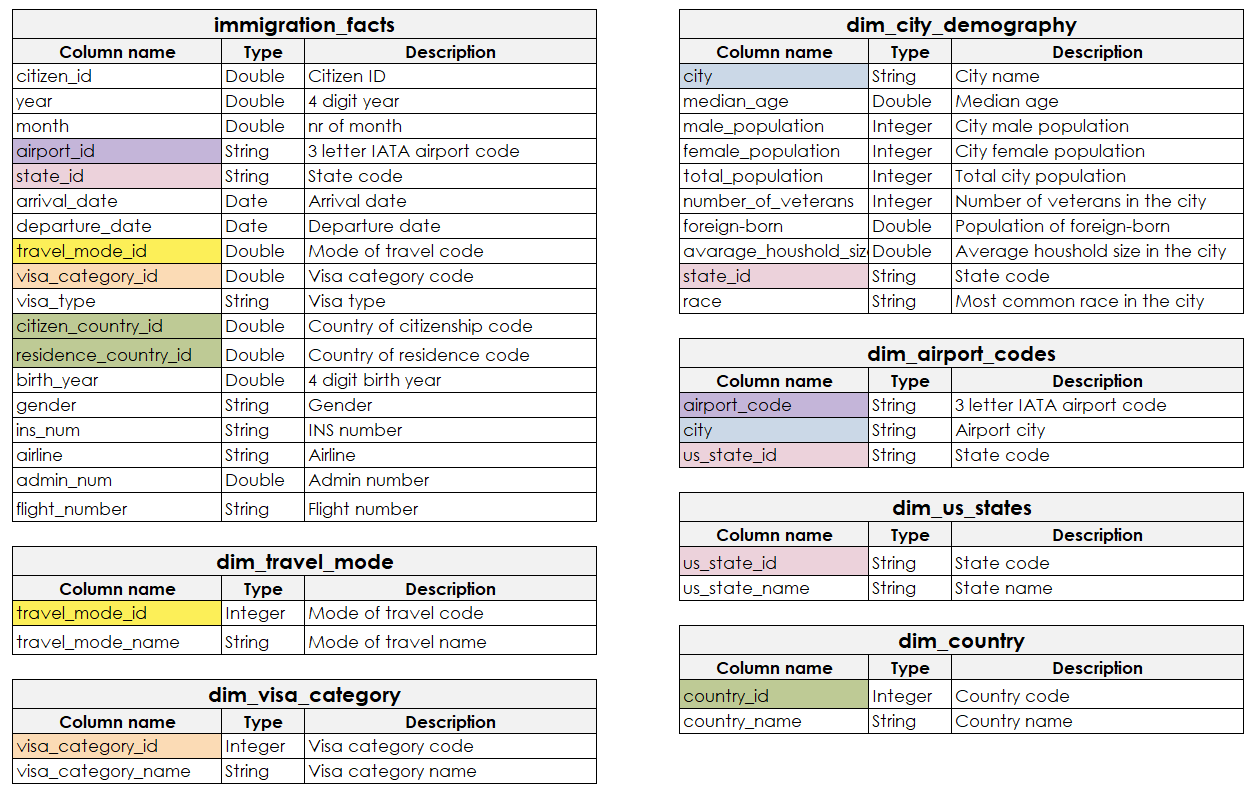

### Step 5: Complete Project Write Up

#### Tools and technologies
1. Pandas for exploring data, since it's easy to use
2. PySpark for processing large amounts of data
3. AWS S3 for storing a data lake

#### Data refreshes
1. Immigration data - monthly refreshes
2. City demographic data - yearly refreshes

#### Future scenarios
1. The data is increased by 100x

One using spark on just one machine is not enough, the etl script could be deployed using AWS EMR.

2. The data populates a dashboard that must be updated on a daily basis by 7am every day

ETL process could be scheduled to run every day using Apache Airflow.

3. The database needed to be accessed by 100+ people.

Since AWS Redshift can handle maximum of 500 connections, this database could be moved to Redshift to handle the increased demand.